In [2]:
import numpy as np
from numpy import linalg as LA
from scipy.optimize import root
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import csv
import pandas as pd
from scipy.stats import norm

# define matplotlib style
mpl.style.use("classic")
mpl.rc("xtick", labelsize=15)
mpl.rc("ytick", labelsize=15)
mpl.rc("xtick.major", size=14, width=2)
mpl.rc("xtick.minor", size=7, width=2, visible=True)
mpl.rc("ytick.major", size=14, width=2)
mpl.rc("ytick.minor", size=7, width=2, visible=True)
mpl.rc("lines", linewidth=2, markersize=5)
mpl.rc("axes", linewidth=2, labelsize=15, labelpad=2.5)
mpl.rc("legend", fontsize=15, loc="best", frameon=True, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")
mpl.rc("axes", titlesize=20, titlepad=10)

Dataset 1: Fitted parameters: A = -0.1904 ± 0.0031 m, T = 2.5876 ± 0.0010 s, phi = 37.7516 ± 0.0148 rad, offset = 0.0486 ± 0.0004 m, gamma = 0.0046 ± 0.0011 s⁻¹
Dataset 1: Fitted period T = 2.5876 ± 0.0010 s, gamma = 0.0046 ± 0.0011 s⁻¹
Dataset 1: Calculated g = 9.88 ± 0.12 m/s²
Dataset 2: Fitted parameters: A = -0.2960 ± 0.0023 m, T = 2.5914 ± 0.0007 s, phi = 30.9677 ± 0.0085 rad, offset = 0.0139 ± 0.0004 m, gamma = 0.0031 ± 0.0006 s⁻¹
Dataset 2: Fitted period T = 2.5914 ± 0.0007 s, gamma = 0.0031 ± 0.0006 s⁻¹
Dataset 2: Calculated g = 9.85 ± 0.12 m/s²
Dataset 3: Fitted parameters: A = -0.2084 ± 0.0013 m, T = 2.3359 ± 0.0012 s, phi = -0.2565 ± 0.0063 rad, offset = -0.0091 ± 0.0005 m, gamma = 0.0033 ± 0.0013 s⁻¹
Dataset 3: Fitted period T = 2.3359 ± 0.0012 s, gamma = 0.0033 ± 0.0013 s⁻¹
Dataset 3: Calculated g = 9.77 ± 0.15 m/s²
Dataset 4: Fitted parameters: A = 0.3172 ± 0.0024 m, T = 2.3213 ± 0.0006 s, phi = 19.0915 ± 0.0077 rad, offset = -0.0276 ± 0.0004 m, gamma = 0.0048 ± 0.0007 s⁻

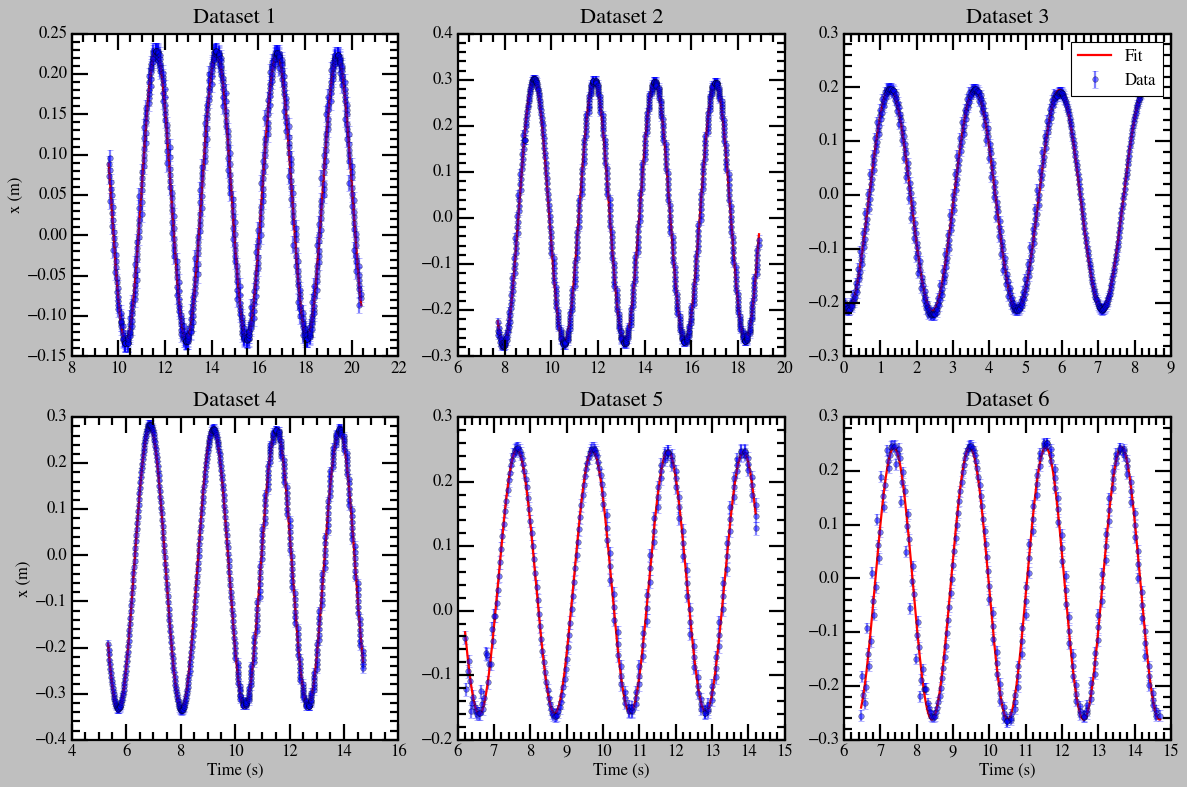

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the damped pendulum model.
def damped_pendulum_model(t, A, T, phi, offset, gamma):
    """
    Damped pendulum displacement model.
    
    Parameters:
        t : array_like
            Time values.
        A : float
            Initial amplitude.
        T : float
            Period.
        phi : float
            Phase offset.
        offset : float
            Vertical offset.
        gamma : float
            Damping coefficient.
            
    Returns:
        x : array_like
            Displacement at time t.
    """
    return A * np.exp(-gamma * t) * np.cos(2 * np.pi * t / T + phi) + offset

# List of CSV file names.
file_names = ["length_1591.csv", "length_1591_2.csv", "length_1267.csv", 
              "length_1267_2.csv", "length_0988.csv", "length_0988_2.csv"]

# Corresponding pendulum lengths (in meters) adjusted with an extra offset.
lengths = np.array([1.591, 1.591, 1.267, 1.267, 0.988, 0.988]) + 0.168/2

# Prepare lists to store the gravitational constant and its systematic error from each dataset.
g_values = []
g_sys_errors = []

# Create subplots: 2 rows, 3 columns.
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Define grid dimensions for labeling logic.
nrows, ncols = 2, 3

for i, file_name in enumerate(file_names):
    ax = axes[i]
    data = pd.read_csv(file_name)
    t_data = data['t'].values
    x_data = data['x'].values
    
    # Assume constant error for each data point.
    sigma_data = np.full_like(t_data, 0.01)
    
    # Initial guesses: Amplitude, Period, Phase, Offset, Damping.
    p0 = [
        (np.max(x_data) - np.min(x_data)) / 2,  # A
        1.0,                                   # T (s)
        0.0,                                   # phi
        np.mean(x_data),                       # offset
        0.1                                    # gamma (s⁻¹)
    ]
    
    # Perform the chi² fit.
    popt, pcov = curve_fit(damped_pendulum_model, t_data, x_data, sigma=sigma_data,
                           absolute_sigma=True, p0=p0)
    A_fit, T_fit, phi_fit, offset_fit, gamma_fit = popt
    A_err, T_err, phi_err, offset_err, gamma_err = np.sqrt(np.diag(pcov))
    print(f"Dataset {i+1}: Fitted parameters: A = {A_fit:.4f} ± {A_err:.4f} m, T = {T_fit:.4f} ± {T_err:.4f} s, phi = {phi_fit:.4f} ± {phi_err:.4f} rad, offset = {offset_fit:.4f} ± {offset_err:.4f} m, gamma = {gamma_fit:.4f} ± {gamma_err:.4f} s⁻¹")
    
    # Calculate gravitational constant for a simple pendulum:
    # T = 2π √(L/g)  ->  g = 4π² L / T²
    L = lengths[i]
    L_err = 0.02  # Uncertainty in the pendulum length (systematic)
    g = 4 * np.pi**2 * L / T_fit**2
    # Propagate uncertainties: ∂g/∂L = 4π²/T² and ∂g/∂T = -8π²L/T³
    g_err = np.sqrt((4 * np.pi**2 * L_err / T_fit**2)**2 + (8 * np.pi**2 * L * T_err / T_fit**3)**2)
    
    print(f"Dataset {i+1}: Fitted period T = {T_fit:.4f} ± {T_err:.4f} s, gamma = {gamma_fit:.4f} ± {gamma_err:.4f} s⁻¹")
    print(f"Dataset {i+1}: Calculated g = {g:.2f} ± {g_err:.2f} m/s²")
    
    g_values.append(g)
    g_sys_errors.append(g_err)
    
    # Plot the data and the fitted curve on the corresponding subplot.
    t_fit = np.linspace(np.min(t_data), np.max(t_data), 1000)
    x_fit = damped_pendulum_model(t_fit, *popt)
    ax.errorbar(t_data, x_data, yerr=sigma_data, fmt='o', alpha=0.5, label=f'Data')
    ax.plot(t_fit, x_fit, label=f'Fit', color='red')
    
    # Only add x-label for bottom row and y-label for left column.
    row = i // ncols
    col = i % ncols
    if row == nrows - 1:
        ax.set_xlabel("Time (s)")
    else:
        ax.set_xlabel("")
    if col == 0:
        ax.set_ylabel("x (m)")
    else:
        ax.set_ylabel("")
    
    ax.set_title(f"Dataset {i+1}")
    if i == 2:
        ax.legend()

# Calculate the statistical uncertainty from the scatter of the 6 g measurements.
g_values = np.array(g_values)
n = len(g_values)
g_mean = np.mean(g_values)
g_stat = np.std(g_values, ddof=1) / np.sqrt(n)  # Standard error of the mean.
# Average the systematic uncertainty from the fits.
g_sys_avg = np.mean(g_sys_errors)

print("\nOverall gravitational constant from 6 measurements:")
print(f"g = {g_mean:.2f} m/s²")
print(f"Statistical uncertainty (from scatter): ± {g_stat:.2f} m/s²")
print(f"Systematic uncertainty (from fits): ± {g_sys_avg:.2f} m/s²")

plt.tight_layout()
plt.savefig("damped_pendulum_fits.pdf")
plt.show()